Transfer Learning Using https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae tutorial

In [198]:
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [200]:
import pycocotools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.utils.data
from PIL import Image
import utils as until
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import math
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

# from torch.vision import enginetrain
from engine import train_one_epoch, evaluate

### Data preprocessing

In [201]:
import re
cv2.startWindowThread()

class ExpressionImageDataset(Dataset):
    """
    An expression-level dataset.
    """
    def __init__(self, pickle_file, transform=None, colab=True):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))
            if colab:
                self.df_data["img_path"] = self.df_data["img_path"].apply(lambda x:"".join(x.split("all_years")[1:]))
                self.df_data["img_path"] = self.df_data["img_path"].apply(lambda x: "/content/drive/My Drive"  +  re.sub(r'\\', "/", x))#/10617 Data
                
        # print(self.df_data['img_path'].iloc[0])

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df_data.iloc[idx]
                
        traces_data = row['traces_data']
        img_path = row['img_path']
        tokens = row['tokens']
        latex = row['latex']
        
        # CV2 will read the image with white being 255 and black being 0, but since
        # our token-level training set uses binary arrays to represent images, we
        # need to binarize our image here as well.
        image_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_binarized = cv2.threshold(image_raw, 127, 255, cv2.THRESH_BINARY)[1]
        image_bitmap = image_binarized / 255.0 #change to be 1's and 0's
        
        sample = {
            'image': image_binarized,
            'image_bitmap': image_bitmap,
            'traces_data': traces_data,
            'tokens': tokens,
            'latex': latex
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [202]:
train_exp_path = "/content/drive/My Drive/train/Copy of train.pickle" #10617 Data
test_exp_path = '/content/drive/My Drive/test/Copy of test.pickle' #10617 Data/

# print('train')
train_exp_set = ExpressionImageDataset(train_exp_path)
# print('test')
test_exp_set = ExpressionImageDataset(test_exp_path)

In [5]:
sample = train_exp_set.__getitem__(0)

In [6]:
test_traces_data = train_exp_set[2]['traces_data']

def get_traces_data_stats(traces_data):
    all_coords = []
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            all_coords.extend(trace)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height

def get_trace_group_bounding_box(trace_group):
    all_coords = []
    for t in trace_group:
        all_coords.extend(t)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height
    

def draw_traces_data(traces_data):
    im_x_min, im_y_min, width, height = get_traces_data_stats(traces_data)
    
    # Scale the image down.
    max_dim = 1000 # Maximum dimension pre-pad.
    sf = 1000 / max(height, width)
    scaled_height = int(height * sf)
    scaled_width = int(width * sf)
    
    image = np.ones((scaled_height, scaled_width))
    
    # Draw the traces on the unscaled image.
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            trace = np.array(trace)
            trace -= np.array([im_x_min, im_y_min])
            trace = (trace.astype(np.float64) * sf).astype(int)
            
            for coord_idx in range(1, len(trace)):
                cv2.line(image, tuple(trace[coord_idx - 1]), tuple(trace[coord_idx]), color=(0), thickness=5)
            
    # Pad the scaled image.
    pad_factor = 0.05
    pad_width = ((int(pad_factor * scaled_height), int(pad_factor * scaled_height)), 
                 (int(pad_factor * scaled_width), int(pad_factor * scaled_width)))
    image = np.pad(image, 
                     pad_width=pad_width, 
                     mode='constant', 
                     constant_values=1)
    
    # Binarize.
    image = (image > 0).astype(int) 
    
    # Open CV wants images to be between 0 and 255.
    image *= 255
    image = image.astype(np.uint8)
    
    boxes = []
    
    # Get bounding boxes.
    for pattern in traces_data:
        trace_group = pattern['trace_group']
        rect_x_min, rect_y_min, rect_width, rect_height = get_trace_group_bounding_box(trace_group)
        
        rect_x_min = (rect_x_min - im_x_min) * sf + pad_width[1][0]
        rect_y_min = (rect_y_min - im_y_min) * sf + pad_width[0][0]
        
        rect_width *= sf
        rect_height *= sf
        
        # Convert bounding box coords to integers.
        rect_x_min = int(rect_x_min)
        rect_y_min = int(rect_y_min)
        rect_width = int(rect_width)
        rect_height = int(rect_height)
            
        boxes.append((rect_x_min, rect_y_min, rect_x_min + rect_width, rect_y_min + rect_height))
    
    return image, boxes
    
image, boxes = draw_traces_data(test_traces_data)
print(image.shape)
print(boxes)

(126, 1100)
[(50, 15, 56, 102), (75, 31, 132, 113), (192, 18, 201, 116), (465, 21, 476, 121), (514, 27, 558, 115), (590, 29, 638, 108), (877, 12, 926, 109), (967, 5, 1049, 89), (281, 15, 373, 118), (690, 19, 805, 116)]


In [ ]:
true_image = np.array(image, copy=True)
for box in true_boxes:
    rect_x_min, rect_y_min, rect_width, rect_height = box
    true_image = cv2.rectangle(true_image, 
                  (int(rect_x_min), int(rect_y_min)), 
                  (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
                  (0), 
                  5)

print('Image with true boxes:')
plt.imshow(true_image, cmap='gray')
plt.show()


### Making mini Object Recognition Dataset:


Make a Pickle that for objet detection which contains the numpy images (normalized) as well as the predicted boxes.

In this case, a smaller dataframe was made just to test the model to see if the flow works. ( ~1000 examples). Other other notebook is run for the entire train/test set to get the entire dataset pickle.



In [203]:
%%time
box_list = []
numpy_list = []

short_len = 700 #not entire dataset

for i in range(len(train_exp_set.df_data[:short_len])):
    #get the specific row:
    curr_row = train_exp_set[i]
    test_traces_data = curr_row['traces_data']
    #get trace data for row:
    image, boxes = draw_traces_data(test_traces_data)

    #double check right row:
    if str(test_traces_data[0].values()) == str(train_exp_set.df_data.iloc[i]["traces_data"][0].values()): #check to make srue traces same:
      #append to lists in order to later append to train df
      box_list.append(boxes)
      numpy_list.append(image)
    else: #any errors?
      print("error at line {}".format(i))

print(len(train_exp_set.df_data), len(box_list)) #shapes ?

short_df = train_exp_set.df_data[:short_len].copy() #create a df (short since not entire dataset)

CPU times: user 5.44 s, sys: 356 ms, total: 5.79 s
Wall time: 6.77 s


In [11]:
### OHE: IS THIS EVEN NEEDED? ###
from sklearn.preprocessing import OneHotEncoder as OHE

#want OHE labels
tokens = train_exp_set.df_data["tokens"].sum()
ohe_categories = pd.Series(tokens).unique()
ohe_categories, len(ohe_categories)

handle = "ignore" #or error or ignore... maybe ignore is safer

ohe = OHE(categories = [np.array(sorted(ohe_categories))],  handle_unknown=handle)

ohe_input = train_exp_set.df_data["tokens"].apply(lambda x: ohe.fit_transform(np.array(x).reshape(-1,1)))

In [12]:
#add images, boxes and OHE labels to df
short_df["true_location"] = box_list
short_df["numpy_image"] = numpy_list
short_df["labels"] = ohe_input[:short_len]

In [13]:
test_split = round(short_len * .8) #split at around 80%

#since only using training data, split into two dataframes/pickles for model work.
short_df[["true_location", "numpy_image", "img_path","tokens", "labels"]][:test_split].to_pickle("train_short_2000_test_df.pkl")
short_df[["true_location", "numpy_image", "img_path","tokens", "labels"]][test_split:].to_pickle("test_short_2000_test_df.pkl")

### Pytorch object detection tutorial


In [107]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, path, data):
    self.path = path
    self.data = data
    pickle_file = os.path.join(self.path, self.data)

    with open(pickle_file, 'rb') as f:
        self.df_data = pd.DataFrame(pickle.load(f))
  def __getitem__(self, index):
    row = self.df_data.iloc[index]
    images = row["numpy_image"]/255 #normalize images
    height = images.shape[0]
    width = images.shape[1]
    pil_image = Image.fromarray(np.uint8(images))
    images = torch.tensor(row["numpy_image"]/255).view(1,height,width).float() #need to reshape to (C, H, W) but 1 channel so 1. also turn to float
    images = images.view(1, height, width)

    box = np.array(row["true_location"])
    # area = (box[:,2] - box[:,0]) * (box[:,3] - box[:,1])
    #add buffer of boxes (since some boxes are width or height 0)
    box[:,0] -=1
    box[:,1] -=1
    box[:,2] +=1
    box[:,3] +=1

    #how many objects?
    num_classes = len(box)

    img_info = {}
    img_info["num_classes"] = torch.tensor(num_classes) #more like how many boxes are present
    img_info["boxes"] = torch.tensor(box, dtype=torch.int32) #make boxes integers
    img_info["image_index"] = torch.tensor(index) #image number
    # img_info["box_area"] =  #do we want this
    # img_info["tokens"] = torch.tensor(row["tokens"])
    img_info["labels"] = torch.tensor(row["labels"].toarray().sum(axis=0), dtype=torch.int64) #make labels ints

    return images, img_info

  def __len__(self):
    return len(self.df_data)
    




    

In [205]:
import os
obj_train_pickle = "train_short_2000_test_df.pkl"
obj_test_pickle = "test_short_2000_test_df.pkl"

train_img_data = ImageDataset("/content", "train_short_2000_test_df.pkl") 
test_img_data = ImageDataset("/content", "test_short_2000_test_df.pkl") 

### Modeling
using pretrained resnet 50


In [110]:
#pretrained model
mod = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #want pretrained
model = mod.float() #keep float or double consistent

In [111]:
#changing the model:
num_classes = 101 #is this the right thing to divide by?

#number of input features:
input_features = model.roi_heads.box_predictor.cls_score.in_features

#change last layer
model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes) #output number of classes based on number of tokens


In [134]:
#put data into dataloaders:
batch_size = 4
shuffle = False
num_workers = 1

#preparing data
train_loader = torch.utils.data.DataLoader(
    train_img_data, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers, collate_fn=until.collate_fn #need this to have images of different size
)
test_loader = torch.utils.data.DataLoader(
    test_img_data, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers, collate_fn=until.collate_fn
)

In [127]:
print(len(train_loader), len(test_loader))

#also collect garbage and throw out!
import gc
gc.collect()

(63, 25)

### Training the model

In [128]:
#see if available device (GPU)
torch.cuda.is_available()
device = torch.device("cuda")

#move to device
model.to(device)

#optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#they added in a lr scheduler, should we do that?

In [138]:
#train for certain number of epochs (verbose)
epochs = 5
model = model.float()
train_one_epoch(model, optimizer, train_loader, device=device, epoch=epochs, print_freq=100)

first one
Epoch: [5]  [  0/125]  eta: 0:03:04  lr: 0.001000  loss: 7.4827 (7.4827)  loss_classifier: 4.6639 (4.6639)  loss_box_reg: 0.2808 (0.2808)  loss_objectness: 2.2009 (2.2009)  loss_rpn_box_reg: 0.3372 (0.3372)  time: 1.4747  data: 0.1449  max mem: 13886
first one
first one
first one
first one
first one
first one
first one
first one
first one
first one
Epoch: [5]  [ 10/125]  eta: 0:01:57  lr: 0.001000  loss: 1.8763 (6.5987)  loss_classifier: 0.5337 (1.2473)  loss_box_reg: 0.2350 (0.3723)  loss_objectness: 0.5137 (4.3197)  loss_rpn_box_reg: 0.2839 (0.6595)  time: 1.0222  data: 0.0224  max mem: 13886
first one
first one
first one
first one
first one
first one
first one
first one
first one
first one
Epoch: [5]  [ 20/125]  eta: 0:01:52  lr: 0.001000  loss: 1.2225 (3.9074)  loss_classifier: 0.3373 (0.7752)  loss_box_reg: 0.1407 (0.2661)  loss_objectness: 0.3354 (2.4004)  loss_rpn_box_reg: 0.2402 (0.4657)  time: 1.0463  data: 0.0103  max mem: 13886
first one
first one
first one
first o

### Predictions

In [192]:
#set model to eval mode:
model.eval()

#sample to get prediction of
index = 3
test_img = train_img_data[index][0].to("cuda")
test_img

#get model predictions
with torch.no_grad():
  prediction = model([test_img])

Image with true boxes:


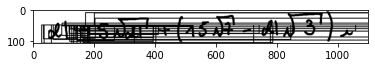

In [209]:
#plot prediction over image:
test_img = train_img_data[index][0].to("cpu")

true_image = test_img.numpy().squeeze(0)

# true_image = np.array(image, copy=True)
for testbox in prediction[0]["boxes"]:

    #maybe image off so multiply by scaling factor??
    sf = 1 #normal

    xmin = testbox[0] * sf
    ymin = testbox[1] * sf
    xmax = testbox[2] * sf
    xmax = testbox[3] * sf

    rect_x_min, rect_y_min, rect_width, rect_height = box
    true_image = cv2.rectangle(true_image, 
                  (int(xmin), int(ymin)), 
                  (int(xmax), int(ymax)), 
                  (0), 
                  2)

print('Image with true boxes:')
plt.figure()
plt.imshow(true_image, cmap='gray')
plt.show()


### TODO:
* i think the model converts to pil image which may be why bounding boxes are so off... Because boxes are based on numpy not pil image...
* drop OHE for labels... How do we also denote there's >1 of a certain symbol??
* train for longer on a validation set (didn't use test data at all).

### Scratch:

In [ ]:
#testing specific inputs with the model
targets = [ train_img_data[2][1], train_img_data[1][1] ]
images = [ train_img_data[1][0].view(1,70, 1097).float().to(device), new_img.view(1,715, 1100).float().to(device)]
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

m = model.float()
m(images, targets)

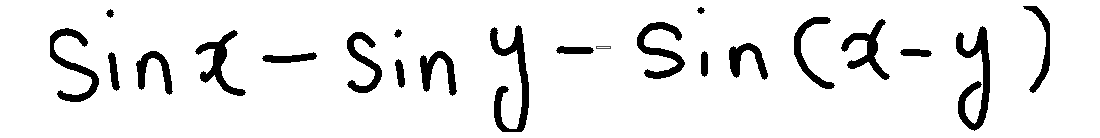

In [206]:
#check to see if pil image will keep the bounding boxes the same... I don't think so.

from PIL import ImageDraw
# [597.8450317382812, 47.35714340209961, 609.9963989257812, 49.35714340209961] 
xmin = 596.8450317382812
ymin =  46.35714340209961
xmax =  610.9963989257812
ymax = 48.35714340209961
tester = Image.fromarray(image)
draw = ImageDraw.Draw(tester)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ='red')
tester

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    """Training loop copied from https://github.com/pytorch/vision/blob/master/references/detection/engine.py """
    model.train()
    metric_logger = until.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', until.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = until.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = until.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger
